## Importación de paquetes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod
from sympy import legendre_poly

## Inicializar espacio de trabajo

In [2]:
init_vprinting()

In [3]:
x, t = symbols('x t')

## Probando Polinomios de Legendre

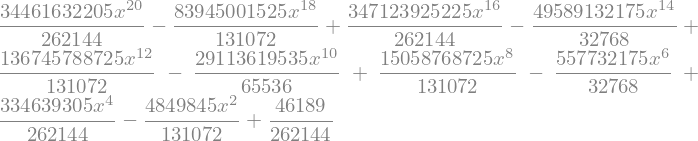

In [4]:
legendre_poly(20)

In [5]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).real_roots():
    print(ii.evalf(n = prec))

-0.99971372677344123368
-0.99849195063959581840
-0.99629513473312514919
-0.99312493703744345965
-0.98898439524299174800
-0.98387754070605701550
-0.97780935848691828855
-0.97078577576370633193
-0.96281365425581552729
-0.95390078292549174285
-0.94405587013625597796
-0.93328853504307954592
-0.92160929814533395267
-0.90902957098252969047
-0.89556164497072698670
-0.88121867938501841557
-0.86601468849716462341
-0.84996452787959128429
-0.83308387988840082354
-0.81538923833917625439
-0.79689789239031447639
-0.77762790964949547563
-0.75759811851970717604
-0.73682808980202070551
-0.71533811757305644646
-0.69314919935580196595
-0.67028301560314101580
-0.64676190851412927983
-0.62260886020370777160
-0.59784747024717872126
-0.57250193262138119132
-0.54659701206509416747
-0.52015801988176305665
-0.49321078920819093357
-0.46578164977335804225
-0.43789740217203151311
-0.40958529167830154253
-0.38087298162462995676
-0.35178852637242172097
-0.32236034390052915172
-0.29261718803847196474
-0.2625881203715

In [6]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).diff().real_roots():
    print(ii.evalf(n = prec))

-0.99927325781121288270
-0.99756443204458700727
-0.99488063852175450652
-0.99122470738337533089
-0.98660024749425876238
-0.98101178781547214851
-0.97446479263170485476
-0.96696566062032725135
-0.95852171991477875079
-0.94914122141852687639
-0.93883333093900718661
-0.92760812032143847119
-0.91547655765222495310
-0.90245049656575054059
-0.88854266467553747995
-0.87376665114599194954
-0.85813689341932410679
-0.84166866311189056371
-0.82437805109443962892
-0.80628195177123525379
-0.78739804657365455315
-0.76774478668452910031
-0.74734137501019825689
-0.72620774741794582242
-0.70436455325718942944
-0.68183313518347961343
-0.65863550830503879636
-0.63479433867222719205
-0.61033292113096122147
-0.58527515656172917539
-0.55964552852644759113
-0.53346907934597929093
-0.50677138563168953965
-0.47957853329494967278
-0.45191709205900723350
-0.42381408949812759428
-0.39529698462937371888
-0.36639364108282767074
-0.33713229987646925224
-0.30754155182231335194
-0.27765030959076779987
-0.2474877794605

## Funciones que generan N collocation points para esquemas LG, LGR y LGL

In [7]:
def LG(N, precission = 20):
    return [ii.evalf(n = precission) for ii in legendre_poly(N, polys = True).real_roots()]

In [8]:
LG(20,8)

In [9]:
def LGR(N, precission = 20):
    pol = legendre_poly(N, polys = True) + legendre_poly(N-1, polys = True)
    return [ii.evalf(n = precission) for ii in pol.real_roots()]

In [10]:
LGR(6,8)

In [11]:
def LGL(N, precission = 20):
    root_list = [ii.evalf(n = precission) for ii in legendre_poly(N-1, polys = True).diff().real_roots()]
    return [-1.,] + root_list + [1.,]

In [12]:
LGL(7,6)

## Bases de Polinomios de Lagrange

In [13]:
#### CREDIT: https://gist.github.com/folkertdev/084c53887c49a6248839 ####

from operator import mul
from functools import reduce, lru_cache
from itertools import chain

# sympy symbols
x = symbols('x')

# convenience functions
product = lambda *args: reduce(mul, *(list(args) + [1]))


# this product may be reusable (when creating many functions on the same domain)
# therefore, cache the result
@lru_cache(16)
def lag_pol(labels, j):
    def gen(labels, j):
        k = len(labels)
        current = labels[j]
        for m in labels:
            if m == current:
                continue
            yield (x - m) / (current - m)
    return expand(product(gen(labels, j)))


def lagrangePolynomial(xs, ys):
    # based on https://en.wikipedia.org/wiki/Lagrange_polynomial#Example_1
    k = len(xs)
    total = 0

    # use tuple, needs to be hashable to cache
    xs = tuple(xs)

    for j, current in enumerate(ys):
        t = current * lag_pol(xs, j)
        total += t

    return total

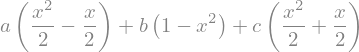

In [14]:
a, b, c = symbols('a b c')
abcpol = lagrangePolynomial([-1, 0, 1], [a, b, c])
abcpol

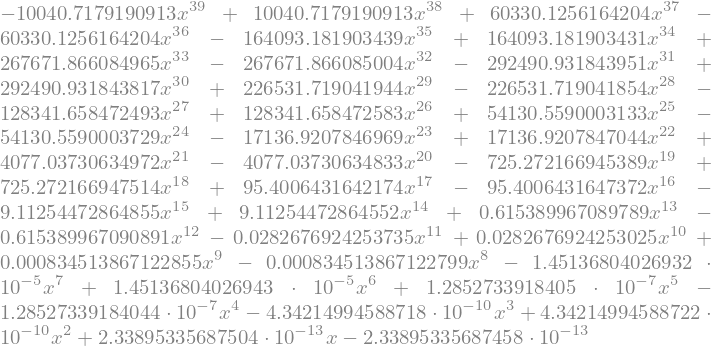

In [15]:
lag_pol(tuple(np.linspace(-1, 1, 40)), 0)

In [18]:
def phi_LGL(N, i):
    return lag_pol(tuple(LGL(N)), i)

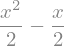

In [19]:
jj = phi_LGL(3,0)
jj

In [20]:
jj.evalf(subs = {x:1})

## Matrices de Derivación LGL

In [21]:
def matrix_D_1(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LGL(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

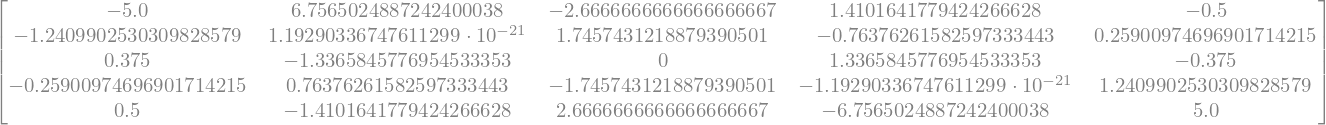

In [22]:
matrix_D_1(4, 20)

In [23]:
def matrix_D_2(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    LN = legendre_poly(n = N, x=x)
    LN_t = [LN.evalf(n = precission, subs = {x:ii}) for ii in taus]
    for l in range(N+1):
        for k in range(N+1):
            if k != l :
                M[k,l] = LN_t[k]/(LN_t[l] * (taus[k]-taus[l]))
    M[0,0] = -N * (N+1)/4
    M[N,N] = N * (N+1)/4
    return M

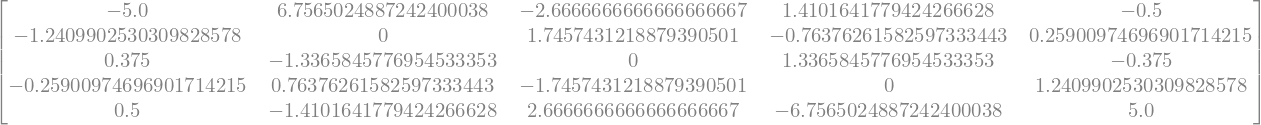

In [24]:
matrix_D_2(4, 20)

In [25]:
def LGL_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LGL(N, precission), letters[:N])

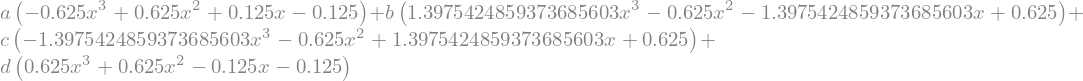

In [26]:
LGL_abcpol(4)

In [27]:
N = 4
letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
abcpoldiff = LGL_abcpol(N).diff(x)
for ii in LGL(N):
    print(abcpoldiff.evalf(n = 20, subs = {x:ii}))

-3.0*a + 4.0450849718747371205*b - 1.5450849718747371205*c + 0.5*d
-0.8090169943749474241*a - 1.6940658945086006781e-21*b + 1.1180339887498948482*c - 0.3090169943749474241*d
0.3090169943749474241*a - 1.1180339887498948482*b + 1.6940658945086006781e-21*c + 0.8090169943749474241*d
-0.5*a + 1.5450849718747371205*b - 4.0450849718747371205*c + 3.0*d


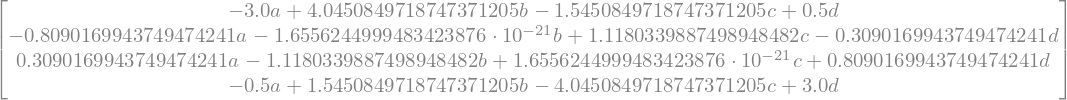

In [28]:
matrix_D_1(N-1,20)@Matrix(letters[:N])

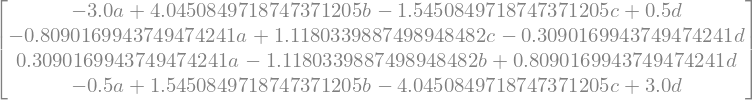

In [29]:
matrix_D_2(N-1,20)@Matrix(letters[:N])

In [30]:
abcpoldiff2 = abcpoldiff.diff(x)
for ii in LGL(N):
    print(abcpoldiff2.evalf(n = 20, subs = {x:ii}))

5.0*a - 9.6352549156242113615*b + 7.1352549156242113615*c - 2.5*d
2.9270509831248422723*a - 5.0*b + 2.5*c - 0.42705098312484227231*d
-0.42705098312484227231*a + 2.5*b - 5.0*c + 2.9270509831248422723*d
-2.5*a + 7.1352549156242113615*b - 9.6352549156242113615*c + 5.0*d


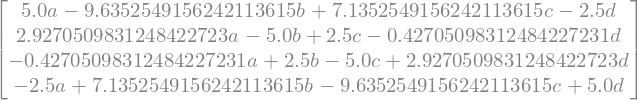

In [31]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

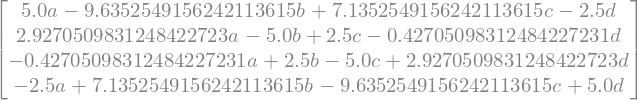

In [32]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [33]:
abcpoldiff3 = abcpoldiff2.diff(x)
for ii in LGL(N):
    print(abcpoldiff3.evalf(n = 20, subs = {x:ii}))

-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d


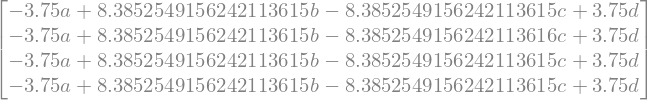

In [34]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

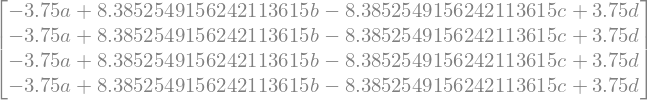

In [35]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [36]:
abcpoldiff4 = abcpoldiff3.diff(x)
for ii in LGL(N):
    print(abcpoldiff4.evalf(n = 20, subs = {x:ii}))

0
0
0
0


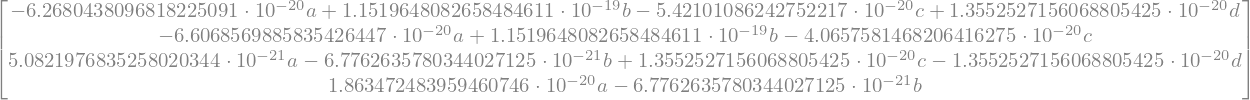

In [37]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

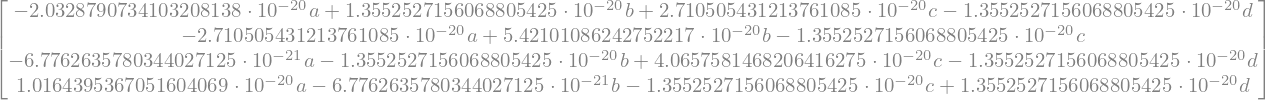

In [38]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

## Problema de ejemplo: bloque que desliza

$$\dot x_1 = x_2$$
$$\dot x_2 = u $$

Minimizar $\int _{t_0} ^{t_1} {u^2}$ sujeto a:

$t_0 = 0\ ,\ t_1 = 1$

$x_2(0) = x_2(1) = 0$

$x_1(0) = 0\ ,\ x_1(1) = 1$

In [40]:
import casadi as cas

### Formulación clásica $\dot x = f(x,u)$

In [80]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-u_sym]
)

In [81]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [82]:
x_opti = opti.variable(N, 2)
u_opti = opti.variable(N)
tau_arr = LGL(N, 20)
t_f = 1
t_0 = 0

In [83]:
from optibot.casadi import sympy2casadi

In [84]:
D_mat = sympy2casadi(matrix_D_2(N-1,20), [], [])

In [85]:
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti

In [86]:
cost = cas.sum1(u_opti**2)

In [87]:
opti.subject_to(x_opti[0,:].T == [0., 0.])
opti.subject_to(x_opti[-1,:].T == [1. ,0.])

In [88]:
for ii in range(N):
    opti.subject_to(dynam_f(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
    opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])

In [89]:
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      116
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       21
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

In [90]:
xx_sol_LGL = sol.value(x_opti)
uu_sol_LGL = sol.value(u_opti) 

In [104]:
q_interp_f = lambdify([x,],lagrangePolynomial(tau_arr, xx_sol_LGL[:,0]))
v_interp_f = lambdify([x,],lagrangePolynomial(tau_arr, xx_sol_LGL[:,1]))
u_interp_f = lambdify([x,],lagrangePolynomial(tau_arr, uu_sol_LGL[:]))


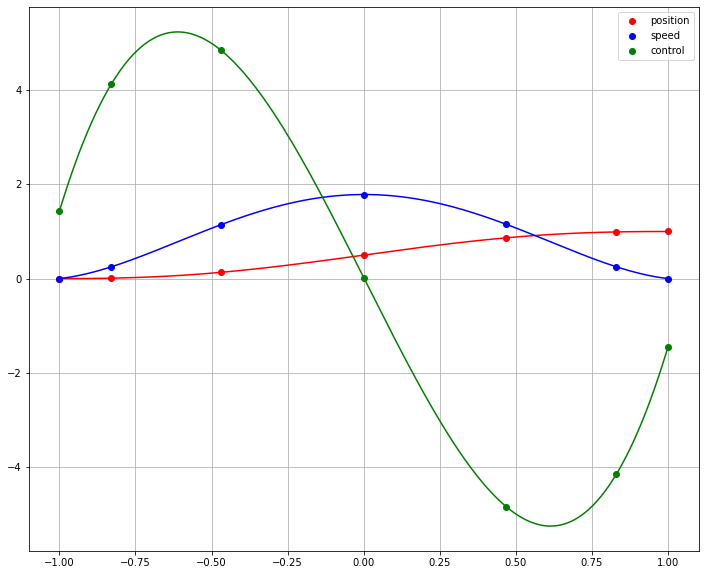

In [109]:
plt.figure(figsize=[12,10])
plt.plot(tau_arr, xx_sol_LGL[:,0], 'ro', label = 'position')
plt.plot(tau_arr, xx_sol_LGL[:,1], 'bo', label = 'speed')
plt.plot(tau_arr, uu_sol_LGL[:], 'go', label = 'control')
N_interp = 300
tau_int_arr = np.linspace(-1, 1, N_interp)
plt.plot(tau_int_arr, q_interp_f(tau_int_arr), 'r')
plt.plot(tau_int_arr, v_interp_f(tau_int_arr), 'b')
plt.plot(tau_int_arr, u_interp_f(tau_int_arr), 'g')
plt.grid()
plt.legend()